In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import plotnine as p9

from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/train_processed.csv')

In [4]:
# Normalize the features

feats = list(set(df.columns) - set(['logSalePrice', 'SalePrice']))
df_normalized = df.copy()
df_normalized[feats] = (df[feats] - df[feats].mean()) / df[feats].std()
# df_normalized['logSalePrice'] = df['logSalePrice']
df_normalized['SalePrice'] = df['SalePrice'] / 1000000  # convert the unit to millions

In [5]:
def train_and_predict(
    df, feats, target, is_log_transformed=True,
    alphas=10 ** np.arange(-3.5, -2.8, 0.01),
    random_state=1000
):
    
    # Train-test split. Use 30% as testing data
    X_train, X_test, y_train, y_test = train_test_split(
        df[feats], df[target], test_size=0.3, random_state=random_state)

    # Lasso cross-validation
    lasso_cv = LassoCV(cv=10, random_state=random_state, alphas=alphas, n_jobs=-1)
    lasso_cv.fit(X_train, y_train)

    # Create a data frame to store how MSE changes with alpha (regularization strength)
    mse_path_df = pd.DataFrame({
        'alpha': lasso_cv.alphas_,
        'mse': np.mean(lasso_cv.mse_path_, axis=1)
    })

    # Predict on test data
    pred_test = lasso_cv.predict(X_test)
    
    # If log transform is used, we transform the data back to the original unit
    if is_log_transformed:
        pred_test = np.exp(pred_test) / 1000000  # in million dollar
        y_test = np.exp(y_test) / 1000000  # in million dollar
    
    # Calculate RMSE and MAPE
    rmse = np.sqrt(np.mean(np.square(pred_test - y_test)))
    mape = np.mean(np.abs(pred_test - y_test) / y_test)
    
    return {
        'mse_path': mse_path_df,
        'pred_test': pred_test,
        'X_test': X_test,  # return X_test for debugging purpose
        'y_test': y_test,
        'rmse': rmse,
        'mape': mape,
        'lasso_cv': lasso_cv  # store the whole lasso_cv object for easier exploration later
    }

In [6]:
def plot_results(res):
    plt.figure(figsize=(10, 7))
    
    # Scatter plot of the prediction
    plt.subplot(221)
    plt.plot(res['pred_test'], res['y_test'], '.')
    plt.xlabel('Predicted Sale Price')
    plt.ylabel('True Sale Price')
    
    # use get_xlim for both x and y to draw "x=y" line
    plt.plot(plt.gca().get_xlim(), plt.gca().get_xlim())
    
    # Residual plot
    plt.subplot(222)
    plt.plot(res['pred_test'], res['y_test'] - res['pred_test'], '.')
    plt.xlabel('Predicted Sale Price')
    plt.ylabel('Residual')
    
    # plot a horizontal line
    plt.plot(plt.gca().get_xlim(), [0, 0])

    # LASSO: mse vs penalty strength
    plt.subplot(212)
    plt.plot(res['mse_path']['alpha'], res['mse_path']['mse'], '.-')
    plt.xlabel('Penalty Strength')
    plt.ylabel('MSE')
    plt.grid()
    print('Test RMSE: {:.3f} million, or {:.2f}k'.format(res['rmse'], res['rmse'] * 1000))
    print('Test MAPE: {:.2%}'.format(res['mape']))
    

## Use log price as the target

In [7]:
res = train_and_predict(df_normalized, feats, 'logSalePrice', is_log_transformed=True)

Test RMSE: 0.033 million, or 32.68k
Test MAPE: 9.73%


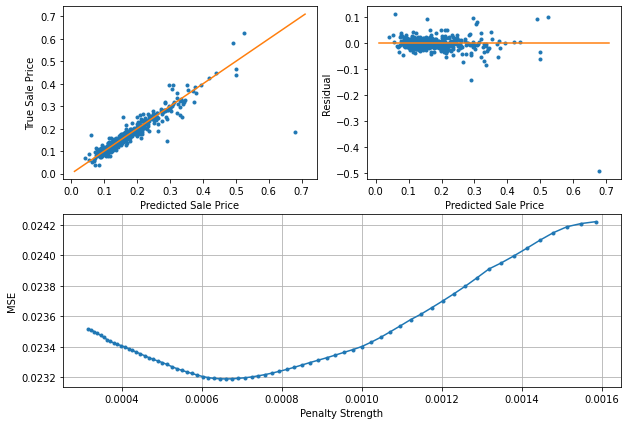

In [8]:
plot_results(res)

## Use price directly as the target

In [9]:
res2 = train_and_predict(df_normalized, feats, 'SalePrice', is_log_transformed=False,
                         alphas=10 ** np.arange(-4, -2, 0.01))

Test RMSE: 0.032 million, or 32.31k
Test MAPE: 11.29%


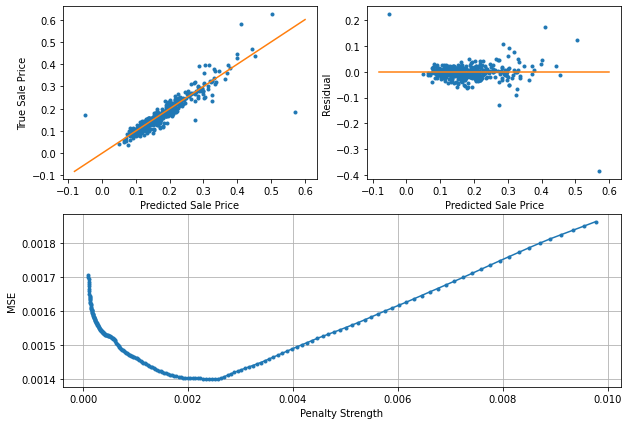

In [10]:
plot_results(res2)

## Analyze the selected features

In [11]:
feat_coef_df = pd.DataFrame({
    'feat_name': res['lasso_cv'].feature_names_in_,
    'coef': res['lasso_cv'].coef_,
    'abs_coef': np.abs(res['lasso_cv'].coef_)
})

In [12]:
# Sort the features based on the absolute value of the coefficients
feat_coef_df = feat_coef_df.sort_values(by='abs_coef', ascending=False)

### Feature Importance

* Use absolute coefficient as a way to measure the importance of the features (Note: the features are normalized)

* Most other top features look reasonable.

    * GrLivArea: the total living area is important, which is in line with our intuition
    
    * Zoning: several zoning variables are important, which is also reasonable
    
* However, "PoolArea" and "PoolQC_Not exist" has the largest coefficients.

    * Maybe the penalty strength is not big enough. However, the penalty strength is chosen by cross-validation. This model has the best accuracy. We should not trust the low-accuracy models, because it could just because the model selected the wrong features so it has the low accuracy.
    
    * Maybe the model is not stable in terms of the selected features in some scenarios.
    
        * Sparse models are not stable! http://users.ece.utexas.edu/~cmcaram/pubs/XuCaramanisMannor.NFL.pdf
        
        * We can verify if the coefficients are stable by running the algorithm multiple times with different random seeds.

#### Feature importance of the first run of the LASSO

* Pool Area and PoolQC_Not exist are very important

In [13]:
feat_coef_df.head(10)

,feat_name,coef,abs_coef
150,PoolArea,0.209505,0.209505
228,PoolQC_Not exist,0.188023,0.188023
47,GrLivArea,0.150733,0.150733
54,MSZoning_RL,0.133888,0.133888
1,LotArea,0.107158,0.107158
67,MSZoning_RM,0.102373,0.102373
252,GrLivArea*LotArea,-0.094924,0.094924
267,MSZoning_FV,0.068539,0.068539
187,PoolQC_Gd,-0.052347,0.052347
99,YearBuilt_sq,0.047632,0.047632


In [14]:
feat_coef_df[
    feat_coef_df.apply(lambda x: 'Pool' in x['feat_name'], axis=1)
]

,feat_name,coef,abs_coef
150,PoolArea,0.209505,0.209505
228,PoolQC_Not exist,0.188023,0.188023
187,PoolQC_Gd,-0.052347,0.052347
111,PoolQC_Fa,-0.021654,0.021654


In [15]:
df['PoolQC_Gd'].value_counts()

0    1457
1       3
Name: PoolQC_Gd, dtype: int64

## Stability of the coefficients

* Run the algorithm multiple times to assess the stability of the model coefficients

In [16]:
res_stability = []
for i in range(50):
    print(i, end=',', flush=True)
    
    # Use different random seed to run the whole training and prediction process
    res_stability.append(
        train_and_predict(df_normalized, feats, 'logSalePrice', is_log_transformed=True, random_state=1000 + i)
    )

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,

In [17]:
feat_coef_df = pd.DataFrame()

# Gather the result for 10 runs of the LASSO
for i in range(50):
    current_res = res_stability[i]
    
    temp_df = pd.DataFrame({
            'run_id': i,
            'feat_name': current_res['lasso_cv'].feature_names_in_,
            'coef': current_res['lasso_cv'].coef_,
            'abs_coef': np.abs(current_res['lasso_cv'].coef_)
    })
    
    feat_coef_df = feat_coef_df.append(temp_df)

# Aggregate the feature coefficients
feat_coef_df = feat_coef_df.groupby('feat_name').agg({
    'coef': [np.mean, np.min, np.max],
    'abs_coef': [np.mean, np.min, np.max]
})
feat_coef_df.columns = ['coef_mean', 'coef_min', 'coef_max', 'abs_coef_mean', 'abs_coef_min', 'abs_coef_max']
feat_coef_df.sort_values(by='abs_coef_mean', ascending=False, inplace=True)
feat_coef_df['rank'] = np.arange(len(feat_coef_df))

#### Now, the mean coefficients from multiple run is more stable

* PoolArea ranks # 19

In [19]:
feat_coef_df.head(30)

,coef_mean,coef_min,coef_max,abs_coef_mean,abs_coef_min,abs_coef_max,rank
feat_name,,,,,,,
GrLivArea,0.161646,0.116640,0.197342,0.161646,0.116640,0.197342,0
GrLivArea*LotArea,-0.157536,-0.275190,0.000000,0.157536,0.000000,0.275190,1
LotArea,0.154318,0.018367,0.253309,0.154318,0.018367,0.253309,2
MSZoning_RL,0.070606,0.005198,0.184458,0.070606,0.005198,0.184458,3
MSZoning_RM,0.049198,0.000000,0.149013,0.049198,0.000000,0.149013,4
MSZoning_FV,0.042491,0.000532,0.103123,0.042491,0.000532,0.103123,5
YearBuilt_sq,0.039250,0.000000,0.076499,0.039250,0.000000,0.076499,6
TotalBsmtSF,0.036525,0.013966,0.055097,0.036525,0.013966,0.055097,7
OverallQual_9,0.033407,0.024984,0.040698,0.033407,0.024984,0.040698,8


### Focus on a few features' ranking

### YrSold

* We thought there was a financial crisis around 2008 and 2009. The house price should be much lower during this time. And this could be reflected in the coefficient for YrSold.

* However, it is not the case, so we double check with zillow's house price index

    * IA was not impacted too much by the financial crisis.

In [20]:
feat_coef_df[['YrSold' in x for x in feat_coef_df.index]]

,coef_mean,coef_min,coef_max,abs_coef_mean,abs_coef_min,abs_coef_max,rank
feat_name,,,,,,,
YrSold_2009,-0.003145,-0.009344,0.000290,0.003157,0.0,0.009344,129
YrSold_2010,-0.000847,-0.006917,0.003247,0.001341,0.0,0.006917,207
YrSold_2007,-0.000882,-0.004314,0.002753,0.001054,0.0,0.004314,222
YrSold_2008,-0.000272,-0.005253,0.003050,0.000805,0.0,0.005253,236


#### Observations:

* The coef for YrSold_2009 is only slightly lower than the coef for other years. It seems the house market was not heavily impacted by the crisis.

In [21]:
from datetime import datetime

In [22]:
df_zillow = pd.read_csv('data/zillow_price_state.csv')

df_zillow = (
    df_zillow[(df_zillow['StateName'] == 'IA') | (df_zillow['StateName'] == 'CA')]
    .melt(
        id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'],
        var_name='dt',
        value_name='price'
    )
)

df_zillow['dt'] = df_zillow['dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

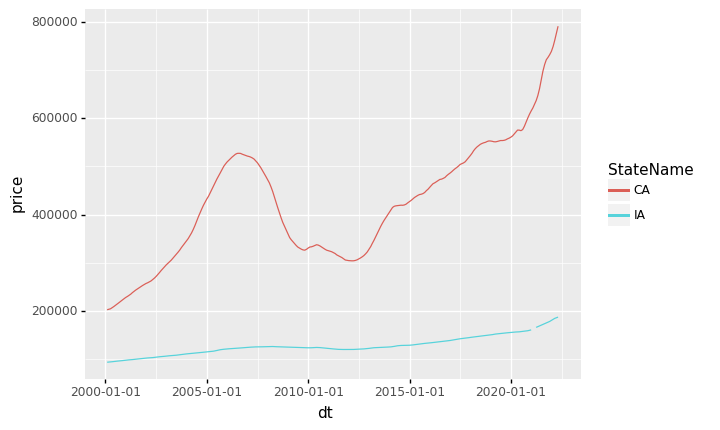

<ggplot: (8728286872098)>

In [23]:
p9.ggplot(df_zillow, p9.aes('dt', 'price', color='StateName')) + p9.geom_line()

#### Observations:

* IA was not impacted, CA was impacted

### Condition

* Whether the house is near artery road --> high noise level

In [24]:
feat_coef_df[['Condition' in x and 'Sale' not in x for x in feat_coef_df.index]]

,coef_mean,coef_min,coef_max,abs_coef_mean,abs_coef_min,abs_coef_max,rank
feat_name,,,,,,,
Condition_Artery,-0.011277,-0.017707,-0.004940,0.011277,0.004940,0.017707,48
Condition_RRAe,-0.010395,-0.014560,-0.004593,0.010395,0.004593,0.014560,53
Condition_Norm,0.009754,-0.001113,0.023780,0.009814,0.000000,0.023780,57
Condition_Feedr,-0.008513,-0.014804,-0.001019,0.008513,0.001019,0.014804,64
Condition_PosN,-0.004285,-0.012491,0.000000,0.004285,0.000000,0.012491,97
Condition_RRNn,0.001902,-0.000963,0.006446,0.001981,0.000000,0.006446,166
Condition_RRNe,-0.001667,-0.005594,-0.000000,0.001667,0.000000,0.005594,190
Condition_PosA,-0.000068,-0.003594,0.006001,0.001302,0.000000,0.006001,208
Condition_RRAn,-0.000832,-0.004585,0.001777,0.001013,0.000000,0.004585,223
